<a id="title_ID"></a>
# Example satellite trail detection in WFC/ACS data with findsat_mrt

This notebook provides examples of how to find satellite trails in ACS/WFC data based on the method described in <a href="https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr2208.pdf">ACS ISR 2022-08</a>. Many of the tools presented here should be applicable to any imaging data.

### Table of Contents:

[Introduction](#intro_ID) <br>
[Imports and Setup](#imports) <br>

[Example 1: Find trails in an FLC image](#example1) <br>
[Example 2: Quick run on an FLC image](#example2)<br>
[Example 3: Find trails in an FLC image using the WFC wrapper](#example3) <br>
[Example 4: Find trails in a DRC image](#example4) <br>
[Example 5: Find trails in a DRC image using the WFC wrapper](#example5)<br>
[Example 6: Create a new kernel for detection](#example6)<br>

[About this Notebook](#about_ID) 

<a id="intro_ID"></a>
## Introduction

Despite being in orbit, HST imaging data still suffers from contamination by artificial satellites that can compromise science data unless they are identified and masked. This notebook presents examples of how to identify satellite trails in ACS/WFC data. The routine is also effective at identifying other linear features duch as <a href="https://hst-docs.stsci.edu/acsdhb/files/60243156/60243162/1/1567011208101/acs_Ch46.2.jpg">diffraction spikes</a> and <a href="https://hst-docs.stsci.edu/acsdhb/chapter-4-acs-data-processing-considerations/4-5-image-anomalies">glint</a> (see <a href="https://hst-docs.stsci.edu/acsdhb/chapter-4-acs-data-processing-considerations/4-5-image-anomalies">Section 4.5 of the ACS DHB</a> for further information). 

A full description of the algorithm is provided in <a href="https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr2208.pdf">ACS ISR 2022-08</a>. To briefly summarize, the Median Radon Transform (MRT) is calculated for an input image and used to identify linear signals in the data. The MRT is similar to the standard <a href="https://en.wikipedia.org/wiki/Radon_transform">Radon Transform</a> except that it calculates the median of the data along all possible paths through an image, rather than the sum. This alteration makes the algorithm more robust against false signals from localized sources (e.g., stars, galaxies) but still very sensitive to persistent linear features, even well-below the background noise level. 

Additional post-processing is done to filter out spurious detections, primarily eliminating them based on trail S/N, width, and persistence across the image. These parameters, especially the maximum allowed trail width, are tuned for ACS/WFC data binned 2x2 and may be different for images from other instruments. Once the final set of trails is identified and characterized, a mask can be created.

The routine provides numerous ways of visualizing the results, as will be demonstrated below.

<a id="imports"></a>
## Imports and Setup

Set your working directory and import the needed packages with the following

In [1]:
#check your own working directory
import os
print('Current working directory is {}'.format(os.getcwd()))

#update as needed with
#os.chdir('/Users/dstark/acs_work/satellite_trails/findsat_mrt/')


Current working directory is /Users/dstark/acs_work/acs-notebook/acs_findsat_mrt


In [2]:
#import modules and setup
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.nddata import bitmask
import numpy as np
import ccdproc
from astroquery.mast import Observations
from acstools.findsat_mrt import TrailFinder

#These are optional configurations
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams['font.serif'] = "Georgia"
plt.rcParams['font.family'] = "serif"

<a id="example1"></a>

## Example 1: Finding trails in an FLC image

FLC images are individual exposures processed by the CALACS pipeline. The data contain two chips, but we only analyze one here. 

We start by reading in an image and doing some pre-processing to remove bad pixels and make the image a bit smaller (to speed up the calculation of the MRT).

Download the example data from <a href="https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:HST/product/jc8m32j5q_flc.fits">here</a> and put it in your working directory.

In [3]:
#Read in the image files and header information
image_file = 'jc8m32j5q_flc.fits'
ext = 4 #ACS image data are in extensions 1 or 4, we'll just use 1 for now
with fits.open(image_file) as h:
    image = h[ext].data #image data
    dq=h[ext+2].data #data quality bitmasks
    
    header = h[0].header #primary header
    image_header = h[1].header #image header


In [4]:
#make a mask for bad pixels. We're ignoring cosmic rays here because routines to make them often partially mask trails
mask = bitmask.bitfield_to_boolean_mask(dq,ignore_flags=[4096,8192,16384])
image[mask == True]=np.nan

#Subtract the background from the image. Here we just do a simple median
image = image-np.nanmedian(image)

In [19]:
#the MRT is computationally demanding and WFC images are big. To help things a bit, let's rebin the images.
image_rebin=ccdproc.block_reduce(image, 2,func=np.nansum)

We now set up TrailFinder. Many of the parameters in the call below are optional (set to their current values by default) but we show them to illustrate the setup. I'm explicitly defining the image header keys to save. These can be useful later when analyzing trail population properties.

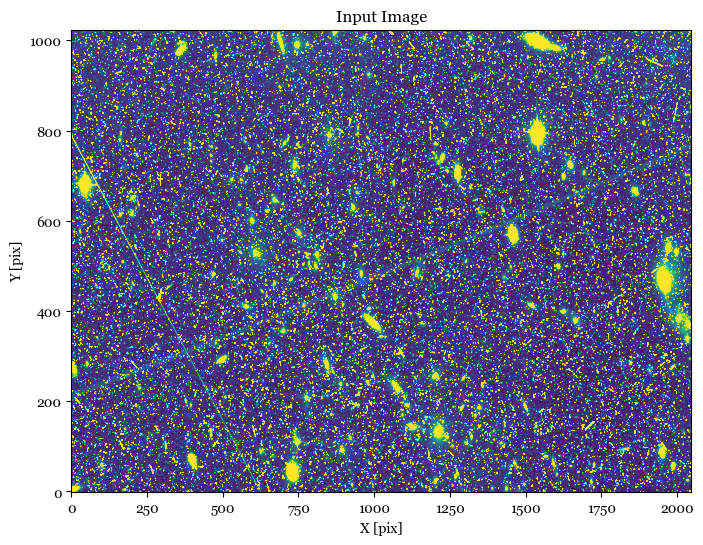

In [20]:
#Now we can set up findsat_mrt
s=TrailFinder(image=image_rebin,
            header=header,
            image_header=image_header,
            save_image_header_keys = ['ROOTNAME','CCDCHIP','CRPIX1','CRPIX2','CRVAL1','CRVAL2','ORIENTAT','RA_APER','DEC_APER','PA_APER'],
            processes=8,
            plot=True,
            threshold=5,
            max_width=75,
            check_persistence=True,
            min_persistence=0.5,
            output_root='example1')

Before we actually run anything, let's plot the image we are analyzing. You should see two satellite trails in this example.

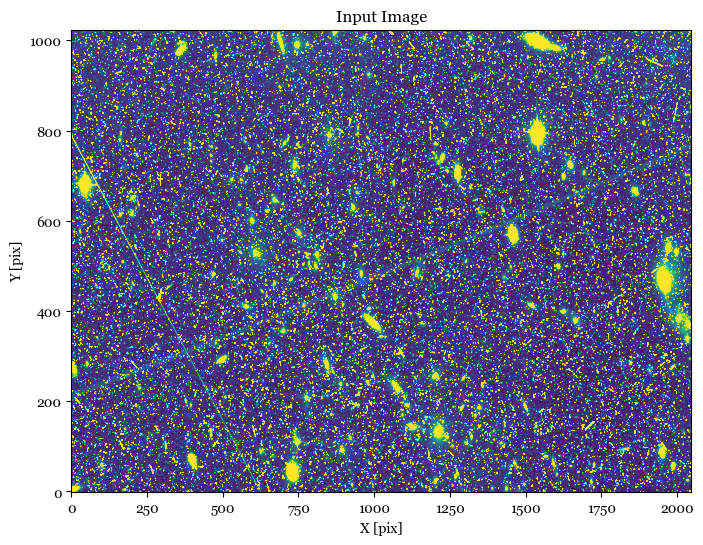

In [21]:
s.plot_image()
#We can see the satellite trail crossing the left side of the image

If you're having trouble seeing the trails, you can adjust the scale keyword (the min and max values to show given as multiples of the image standard deviation)

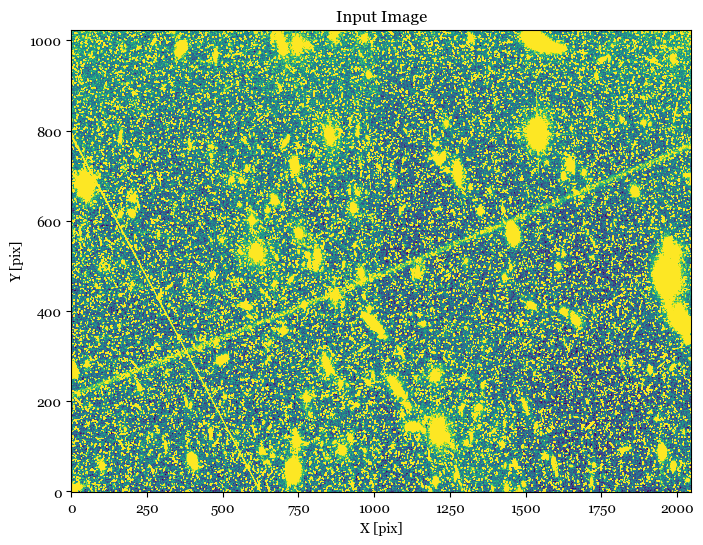

In [22]:
s.plot_image(scale=[-1,1])

Next we run the Median Radon Transform. This step can take some time depending on the image size and number of threads being used. This tutorial assumes 8 threads are available. Adjust as needed.

INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 processes
INFO:findsat_mrt:Saving MRT to ./example1_mrt.png


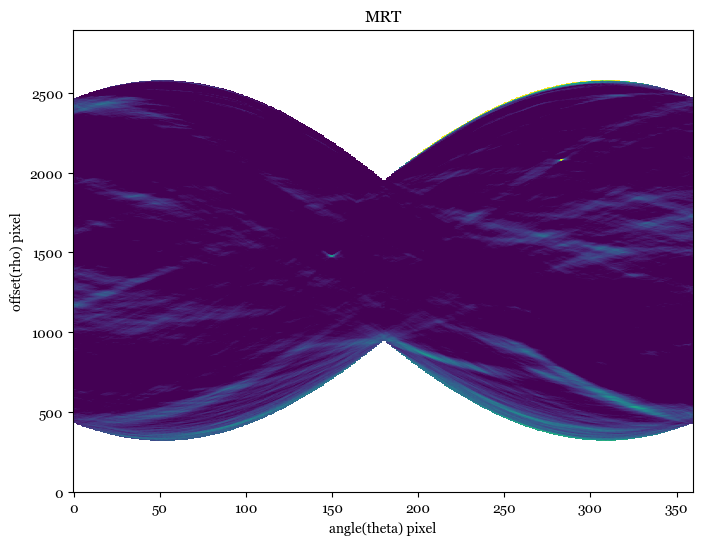

In [23]:
s.processes=8 #adjust thi?s if necessary
s.run_mrt()

Now we will plot the MRT. You may be able to spot the signals from the satellite trails as two somewhat wide point-like sources.

INFO:findsat_mrt:Saving MRT to ./example1_mrt.png


<AxesSubplot: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

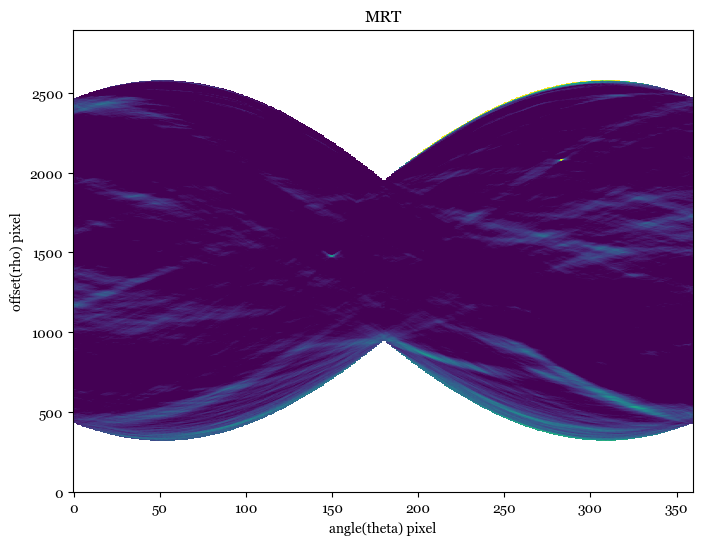

In [24]:
s.plot_mrt()

We next run the source finder on the MRT. Depending on the settings, rhis can pick up a lot more than the actual trails. There are additional steps we'll take later to filter these false detections out. The ones we found and their location on the MRT are shown below.

INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width15.fits
INFO:findsat_mrt:{no} sources found using kernel: 2
INFO:findsat_mrt:2 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width7.fits
INFO:findsat_mrt:{no} sources found using kernel: 4
INFO:findsat_mrt:4 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width3.fits
INFO:findsat_mrt:{no} sources found using kernel: 8
INFO:findsat_mrt:8 sources found using kernel
INFO:findsat_mrt:Removing duplicate sources
INFO:findsat_mrt:8 final sources found
INFO:findsat_mrt:Saving MRT to ./example1_mrt_sources.png


<QTable length=8>
  id      xcentroid          ycentroid             fwhm            roundness      ...       theta               rho                        endpoints                status
int64      float64            float64            float64            float64       ...      float64            float64                     float64[2,2]              int64 
----- ------------------ ------------------ ------------------ ------------------ ... ------------------ ------------------ --------------------------------------- ------
    1 149.83352094833526 1477.0703505919944  9.893894875973562 0.8292584001573645 ...  74.91676047416763 29.070350591994384                0.0 .. 757.2327292124636      0
    2 282.82963970572393 2076.6714622192007  8.531131258761068 0.8722159591245566 ... 141.41481985286197  628.6714622192007                             -0.0 .. 0.0      0
    3 1.8955105145892848 1171.1746240829714 12.038414806751984 0.9241954171652875 ... 0.9477552572946424 -276.8253759170286             738.1750240241082 .. 1023.0      0
    6   1.89141988881136  2413.127072909522 12.446814293611709 0.9262048940283402 ...   0.94570994440568  965.1270729095222            1980.3150982839602 .. 1023.0      0
    7 325.40558445198184  531.0226462164742  12.21011957533328  0.782466494877586 ... 162.70279222599092 -916.9773537835258 1824.6245295125004 .. 308.9119955793549      0
    8 207.51130185000048  846.5876161375713 12.768547365934236  0.828259652940971 ... 103.75565092500024 -601.4123838624287   1463.3274208774326 .. 880.11521414142      0
   11  357.2180104264264 1723.1638304228688  12.13053087051809 0.9285223456875172 ...  178.6090052132132 275.16383042286884                735.8347094401765 .. 0.0      0
   13 1.9185304504369205 2382.6368472434615 11.454661504101521 0.9169104325262873 ... 0.9592652252184602  934.6368472434615            1949.7033492223165 .. 1023.0      0

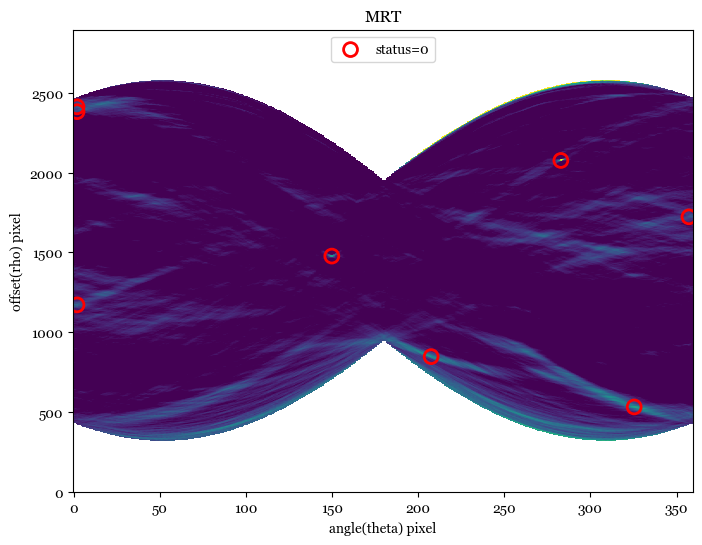

In [25]:
s.find_mrt_sources()

We filter the sources further based on a reassessment of their S/N, width, and persistence. The default parameters (namely width) have been chosen for ACS data. It's possible different defaults will be better for different imaging data.

INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True
INFO:findsat_mrt:Min persistence: 0.5
INFO:utils_findsat_mrt:amplitude of feature: 25.33594810771157
baseline noise: 1.1585551599206303
snr of feature = 20.86857301593415
INFO:utils_findsat_mrt:width of feature = 27.98139457625703
INFO:utils_findsat_mrt:breaking into 21.0 sections for persistence check
Section size for persistence check: 100
INFO:utils_findsat_mrt:Checking persistence, step 1 of 21
INFO:utils_findsat_mrt:amplitude of feature: 26.5560608566918
baseline noise: 5.794985881719303
snr of feature = 3.582592848149085
INFO:utils_findsat_mrt:width of feature = 27.190885335740518
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.582592848149085, 27.190885335740518, 256.71290382785344
INFO:utils_findsat_mrt:Checking persistence, step 2 of 21
INFO:utils_findsat_mrt:amplitude of feature: 39.525694349629795
baseline noise: 4.212498508293069
snr of feature = 8.382957470920472
INFO:ut

INFO:utils_findsat_mrt:width of feature = 5.173546413109648
INFO:utils_findsat_mrt:breaking into 10.0 sections for persistence check
Section size for persistence check: 100
INFO:utils_findsat_mrt:Checking persistence, step 1 of 10
INFO:utils_findsat_mrt:amplitude of feature: 434.35333032583424
baseline noise: 4.805897461772063
snr of feature = 89.3792338019789
INFO:utils_findsat_mrt:width of feature = 3.965034045575578
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 89.3792338019789, 3.965034045575578, 251.96442864043
INFO:utils_findsat_mrt:Checking persistence, step 2 of 10
INFO:utils_findsat_mrt:amplitude of feature: 372.5262322688963
baseline noise: 6.200344812552048
snr of feature = 59.08153474218886
INFO:utils_findsat_mrt:width of feature = 3.9962611517962046
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 59.08153474218886, 3.9962611517962046, 251.81925752230944
INFO:utils_findsat_mrt:Checking persistence, step 3 of 10
INFO:utils_findsat_mrt:amplitude of feature: 274.5557827143889


<QTable length=8>
  id      xcentroid          ycentroid             fwhm            roundness      ... status     mean flux            width               snr            persistence    
int64      float64            float64            float64            float64       ... int64       float64            float64            float64            float64      
----- ------------------ ------------------ ------------------ ------------------ ... ------ ------------------ ------------------ ------------------ ------------------
    1 149.83352094833526 1477.0703505919944  9.893894875973562 0.8292584001573645 ...      2  21.69965813999859  27.98139457625703  20.86857301593415 0.9047619047619048
    2 282.82963970572393 2076.6714622192007  8.531131258761068 0.8722159591245566 ...      2  166.4366616570473  5.173546413109648 101.80126190570022                1.0
    3 1.8955105145892848 1171.1746240829714 12.038414806751984 0.9241954171652875 ...      0  5.257654665771126  80.31573532874066  4.807722384053967                0.0
    6   1.89141988881136  2413.127072909522 12.446814293611709 0.9262048940283402 ...      0  6.266848651467955 151.43146634348085  6.168662324614641                0.0
    7 325.40558445198184  531.0226462164742  12.21011957533328  0.782466494877586 ...      0  13.27392720486676 184.54458078076274   9.16239483226501                0.0
    8 207.51130185000048  846.5876161375713 12.768547365934236  0.828259652940971 ...      0 11.767521425374712  79.31190464846219  8.925402967868523                0.0
   11  357.2180104264264 1723.1638304228688  12.13053087051809 0.9285223456875172 ...      0 3.3792496636384537 136.47850660172705 3.6950085756423197                0.0
   13 1.9185304504369205 2382.6368472434615 11.454661504101521 0.9169104325262873 ...      0  5.794386473073605 102.84728136813328  4.115383353839861                0.0

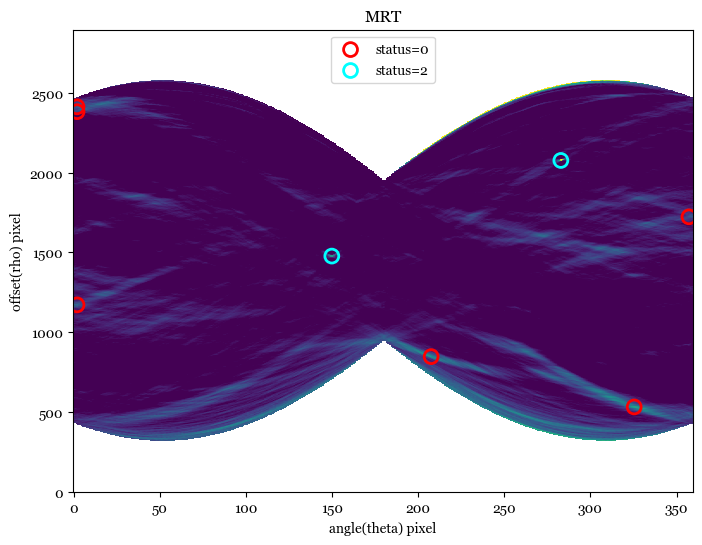

In [26]:
s.filter_sources()
#some extra columns have been added to the source list
s.source_list

Several columns have been added to the source list that characterize the observed streak. Also, the status array has values of 0, 1, and 2 now (it just had 0 before). Status=2 are sources that passed all filtering stages (checks for SNR and width, then persistence). Status=1 are sources that passed the first filtering stage, but not the second. And status=0 are sources that did not pass the filtering steps.

The plot command will automatically overplot the different statuses

INFO:findsat_mrt:Saving MRT to ./example1_mrt_sources.png


<AxesSubplot: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

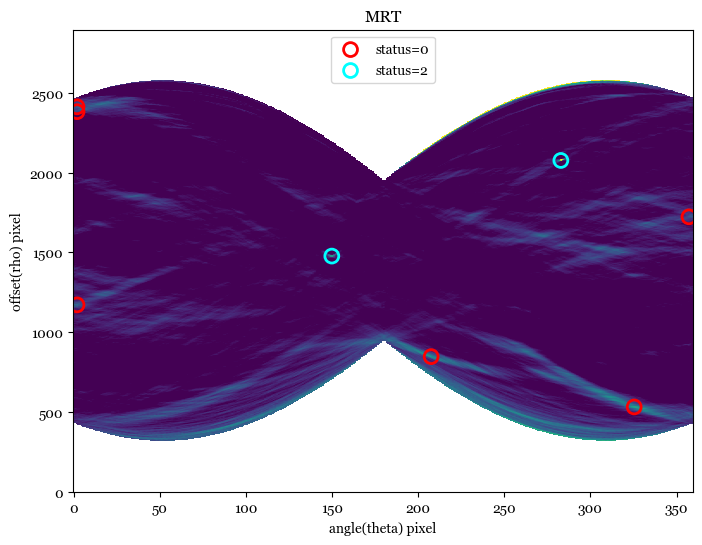

In [27]:
s.plot_mrt(show_sources=True)

Now we can make the mask itself. We make two types of masks, one a simple boolean mask, and one a segementation mask where pixels corresponding to each streak are assigned the ID number. We can also overlay the mask on top of the image to make sure it makes sense.

INFO:findsat_mrt:Saving mask to ./example1_mask.png
INFO:findsat_mrt:Saving segmentation map to ./example1_segment.png


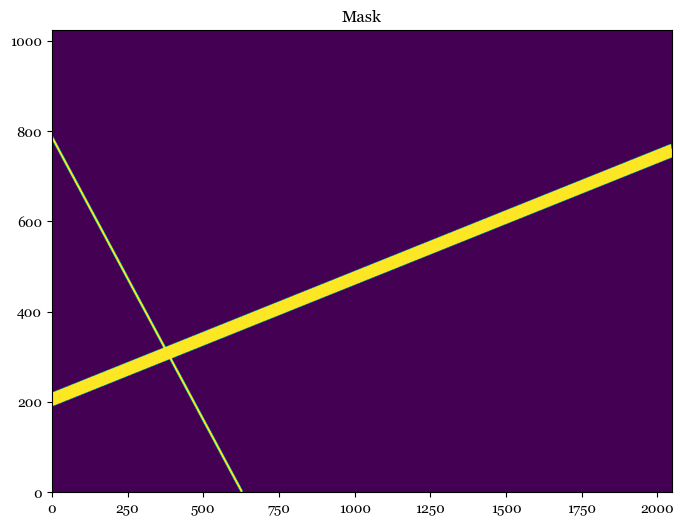

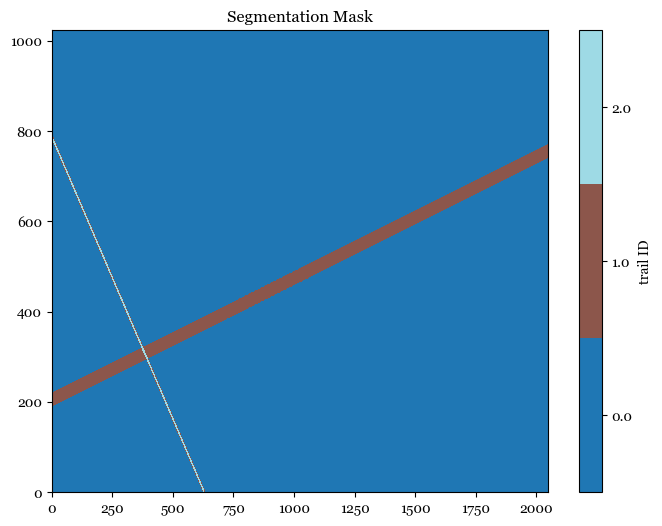

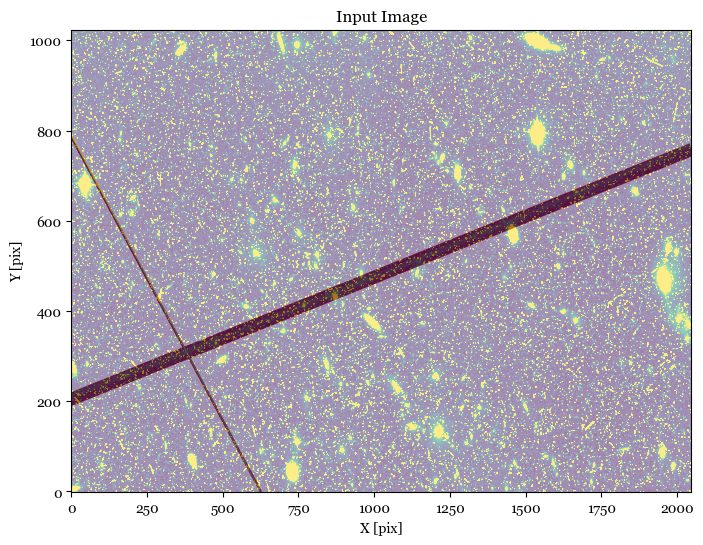

In [28]:
s.make_mask()
s.plot_image(overlay_mask=True)

We can save the results now. You have the optional of saving the catalog, mask, MRT, and a diagnostic image that shows the results. In this example we'll just save everything.

In [30]:
s.save_output()

INFO:findsat_mrt:Saving MRT to ./example1_mrt.png
INFO:findsat_mrt:Saving MRT to ./example1_mrt.png
INFO:findsat_mrt:Wrote diagnostic plot to ./example1_diagnostic.png
INFO:findsat_mrt:wrote catalog ./example1_catalog.fits


Keep in mind that this mask is applicable to the rebinned image. To convert it into a mask that can be applied to the original unbinned image, we need to resample it.

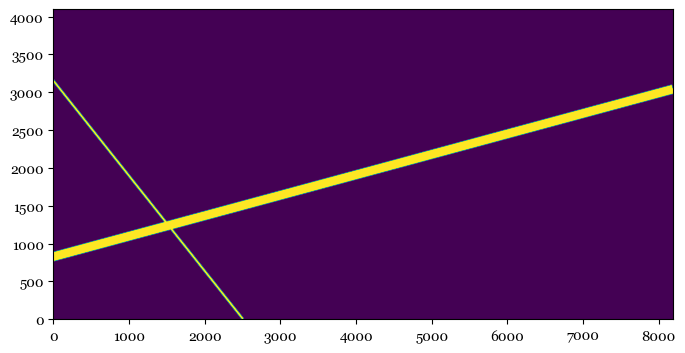

In [31]:
full_mask = ccdproc.block_replicate(s.mask, 4, conserve_sum=False)
fig,ax=plt.subplots()
ax.imshow(full_mask,origin='lower')

## <a id="example2"></a>
## Example 2: Quick run of TrailFinder on an flc image

The above example thoroughly demonstrated the steps to read in a file, pre-process it, and identify trails. One can run many of the steps simultaneously once a file is read in an all parameters set. 

First, we read in and preprocess the data file exactly as before.

In [32]:
#Read in the image files and header information
image_file = 'jc8m32j5q_flc.fits'
ext = 4 #ACS image data are in extensions 1 or 4, we'll just use 1 for now
with fits.open(image_file) as h:
    image = h[ext].data #image data
    dq=h[ext+2].data #data quality bitmasks
    
    header = h[0].header #primary header
    image_header = h[1].header #image header

#make a mask for bad pixels. We're ignoring cosmic rays here because routines to make them often partially mask trails
mask = bitmask.bitfield_to_boolean_mask(dq,ignore_flags=[4096,8192,16384])
image[mask == True]=np.nan

#Subtract the background from the image. Here we just do a simple median
image = image-np.nanmedian(image)

#the MRT is computationally demanding and WFC images are big. To help things a bit, let's rebin the images.
image_rebin=ccdproc.block_reduce(image, 2,func=np.nansum)

And initialize trail finder as before

In [34]:
#Now we can set up findsat_mrt
s2=TrailFinder(image=image_rebin,
            header=header,
            image_header=image_header,
            save_image_header_keys = ['ROOTNAME','CCDCHIP','CRPIX1','CRPIX2','CRVAL1','CRVAL2','ORIENTAT','RA_APER','DEC_APER','PA_APER'],
            processes=8,
            plot=False,
            threshold=5,
            max_width=75,
            check_persistence=True,
            min_persistence=0.5,
            output_root='example2')

If you're feeling ok, run all the subsequent steps all together with the run_all command (this calculates the MRT, finds MRT sources, filters the sources, and saves the output)

In [35]:
s2.run_all()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 processes
INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width15.fits
INFO:findsat_mrt:{no} sources found using kernel: 2
INFO:findsat_mrt:2 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width7.fits
INFO:findsat_mrt:{no} sources found using kernel: 4
INFO:findsat_mrt:4 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width3.fits
INFO:findsat_mrt:{no} sources found using kernel: 8
INFO:findsat_mrt:8 sources found using kernel
INFO:findsat_mrt:Removing duplicate sources
INFO:findsat_mrt:8 final sources found
INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True
INFO:findsat_mrt:Min persistence: 0.5
INFO:utils_findsat_mrt:amplitude of 

INFO:utils_findsat_mrt:amplitude of feature: 27.85278073083034
baseline noise: 5.808566589332881
snr of feature = 3.7951211891037744
INFO:utils_findsat_mrt:width of feature = 25.977067901411147
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.7951211891037744, 25.977067901411147, 257.13435825547896
INFO:utils_findsat_mrt:Checking persistence, step 21 of 21
INFO:utils_findsat_mrt:amplitude of feature: 30.51308144843942
baseline noise: 4.925181053152068
snr of feature = 5.195321779878801
INFO:utils_findsat_mrt:width of feature = 29.015642554091272
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.195321779878801, 29.015642554091272, 258.2306805641226
INFO:utils_findsat_mrt:Number of sections analyzed: 21
Number of sections that passed: 19
persistance score: 0.9047619047619048
INFO:utils_findsat_mrt:amplitude of feature: 166.4366616570473
baseline noise: 1.6190137997500456
snr of feature = 101.80126190570022
INFO:utils_findsat_mrt:width of feature = 5.173546413109648
INFO:utils_findsat_mrt

If we plot the mask, it should look identical to the one in the previous example.

<AxesSubplot: title={'center': 'Mask'}>

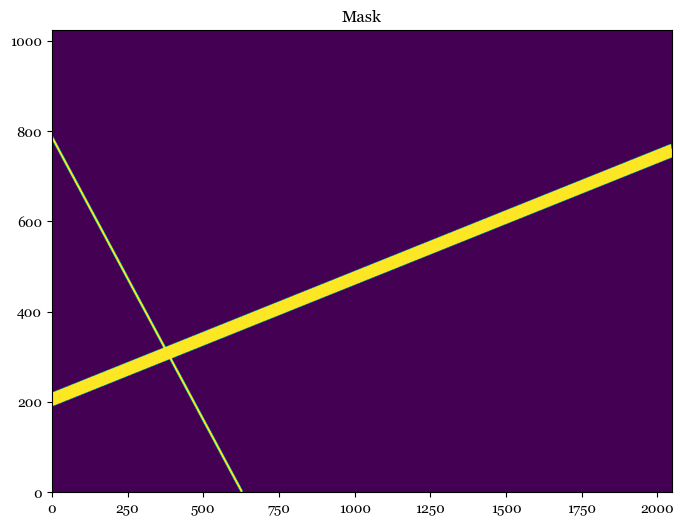

In [36]:
s2.plot_mask()

## <a id="example3"></a>
## Example 3: find trails in an FLC image using the WFC wrapper

The approaches shown in the previous two examples can be useful for any imaging data, not just ACS/WFC data. However, for ACS/WFC data, we provide a convenience wrapper script that performs even more of the steps all together, including reading the image and pre-processing it.

The WfcWrapper class has the same properties as the TrailFinder class, but with a few additional keywords. It contains the additional routines that read the image, rebin, mask, and subtract the background. By default, these will be run automatically when WfcWrapper is initialized, although this can be turned off. In most cases, you probably will only need to adjust the binsize keyword. 

In [41]:
from acstools.findsat_mrt import WfcWrapper
w = WfcWrapper('jc8m32j5q_flc.fits',binsize=2,extension=4,processes=8,output_root = 'example3')

INFO:findsat_mrt:image type is flc
INFO:findsat_mrt:masking bad pixels
INFO:findsat_mrt:Subtracting median background
INFO:findsat_mrt:Rebinning the data by 2


We can plot the image to see that it looks like the one from the last example after preprocessing.

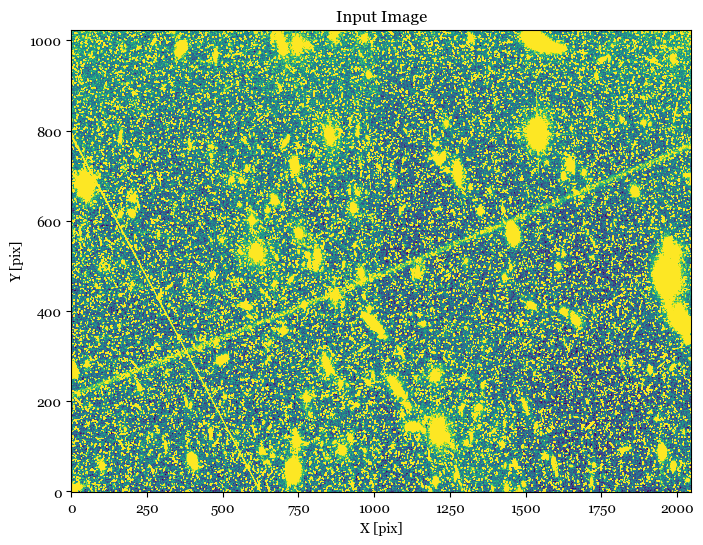

In [42]:
w.plot_image(scale=[-1,1])

From here, everything is the same as the last example:

In [43]:
w.run_mrt()
w.find_mrt_sources()
w.filter_sources()


INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 processes
INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width15.fits
INFO:findsat_mrt:{no} sources found using kernel: 2
INFO:findsat_mrt:2 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width7.fits
INFO:findsat_mrt:{no} sources found using kernel: 4
INFO:findsat_mrt:4 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width3.fits
INFO:findsat_mrt:{no} sources found using kernel: 8
INFO:findsat_mrt:8 sources found using kernel
INFO:findsat_mrt:Removing duplicate sources
INFO:findsat_mrt:8 final sources found
INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True
INFO:findsat_mrt:Min persistence: 0.5
INFO:utils_findsat_mrt:amplitude of 

INFO:utils_findsat_mrt:amplitude of feature: 27.85278073083034
baseline noise: 5.808566589332881
snr of feature = 3.7951211891037744
INFO:utils_findsat_mrt:width of feature = 25.977067901411147
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 3.7951211891037744, 25.977067901411147, 257.13435825547896
INFO:utils_findsat_mrt:Checking persistence, step 21 of 21
INFO:utils_findsat_mrt:amplitude of feature: 30.51308144843942
baseline noise: 4.925181053152068
snr of feature = 5.195321779878801
INFO:utils_findsat_mrt:width of feature = 29.015642554091272
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 5.195321779878801, 29.015642554091272, 258.2306805641226
INFO:utils_findsat_mrt:Number of sections analyzed: 21
Number of sections that passed: 19
persistance score: 0.9047619047619048
INFO:utils_findsat_mrt:amplitude of feature: 166.4366616570473
baseline noise: 1.6190137997500456
snr of feature = 101.80126190570022
INFO:utils_findsat_mrt:width of feature = 5.173546413109648
INFO:utils_findsat_mrt

<QTable length=8>
  id      xcentroid          ycentroid             fwhm            roundness      ... status     mean flux            width               snr            persistence    
int64      float64            float64            float64            float64       ... int64       float64            float64            float64            float64      
----- ------------------ ------------------ ------------------ ------------------ ... ------ ------------------ ------------------ ------------------ ------------------
    1 149.83352094833526 1477.0703505919944  9.893894875973562 0.8292584001573645 ...      2  21.69965813999859  27.98139457625703  20.86857301593415 0.9047619047619048
    2 282.82963970572393 2076.6714622192007  8.531131258761068 0.8722159591245566 ...      2  166.4366616570473  5.173546413109648 101.80126190570022                1.0
    3 1.8955105145892848 1171.1746240829714 12.038414806751984 0.9241954171652875 ...      0  5.257654665771126  80.31573532874066  4.807722384053967                0.0
    6   1.89141988881136  2413.127072909522 12.446814293611709 0.9262048940283402 ...      0  6.266848651467955 151.43146634348085  6.168662324614641                0.0
    7 325.40558445198184  531.0226462164742  12.21011957533328  0.782466494877586 ...      0  13.27392720486676 184.54458078076274   9.16239483226501                0.0
    8 207.51130185000048  846.5876161375713 12.768547365934236  0.828259652940971 ...      0 11.767521425374712  79.31190464846219  8.925402967868523                0.0
   11  357.2180104264264 1723.1638304228688  12.13053087051809 0.9285223456875172 ...      0 3.3792496636384537 136.47850660172705 3.6950085756423197                0.0
   13 1.9185304504369205 2382.6368472434615 11.454661504101521 0.9169104325262873 ...      0  5.794386473073605 102.84728136813328  4.115383353839861                0.0

TypeError: make_mask() got an unexpected keyword argument 'plot'

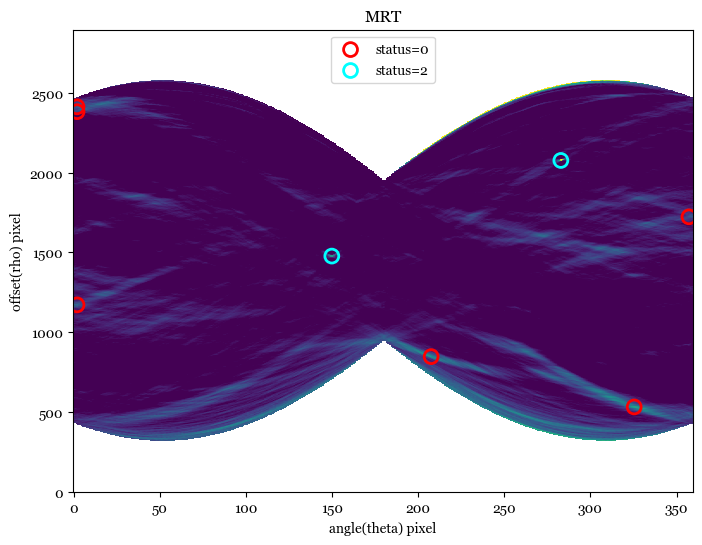

In [44]:
w.plot_mrt(show_sources=True)
w.make_mask(plot=True)

If you're feeling very confident, you can run everything in a single line with the "execute" keyword.

In [ ]:
w = WfcWrapper('jc8m32j5q_flc.fits',binsize=2,extension=4,output_root = 'example3',threads=8,
                execute=True,save_mask=True)

In [ ]:
w.plot_image(overlay_mask=True)

<a id="example4"></a>
## Example 4: Finding trails in a DRC image

Applying findsat_mrt to a DRC image (that shows both chips together) can increase sensitivity by increasing the number of pixels over which we search for trails. The drc files also remove the distortion in the original flc files (though this does not appear to create signficant curvature to most trails). 

Here, we demonstrate the steps that go into preparing a DRC image to be analyzed. The following example will illustrate how to do all of this in a single line.

There are no DQ arrays for the drc files, so we ignore the pre-processing steps that incorporated those.

Download the DRC file <a href="https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:HST/product/hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits">here</a> and move it into your working directory.

In [28]:
#Read in the image files and header information
image_file = 'hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits'
ext = 1
with fits.open(image_file) as h:
    image = h[ext].data #image data
    wht = h[ext+1].data
    image = image*wht #wht is effective exposure time, so this turns it into counts
    
    header = h[0].header #primary header
    image_header = h[1].header #image header

In [29]:
#Flag anything with wht == 0 as bad
image[wht == 0]=np.nan

#Subtract the background from the image. Here we just do a simple median
median = np.nanmedian(image)
image = image-np.nanmedian(image)

In [30]:
#Let's rebin the images
image_rebin=ccdproc.block_reduce(image, 4,func=np.nansum)

Setting up findsat_mrt is essentially the same as earlier examples at this point. We'll use the default settings. In fact, about all the steps from here on out are the same.

In [31]:
#Now we can set up findsat_mrt
s4=TrailFinder(image=image_rebin,threads=8,output_root = 'example4')

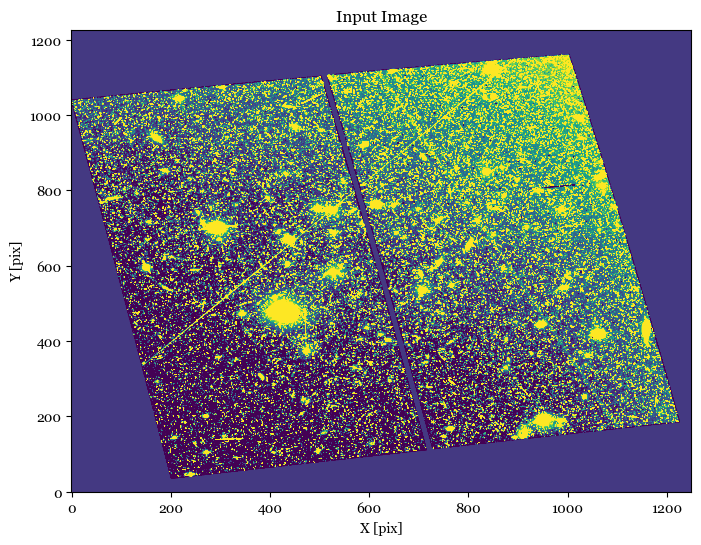

In [32]:
#we can do a quick plot of our image to make sure things look ok
s4.plot_image()

Now run the MRT calculation and plot the results

INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 threads


(360, 2, 1768)


<AxesSubplot: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

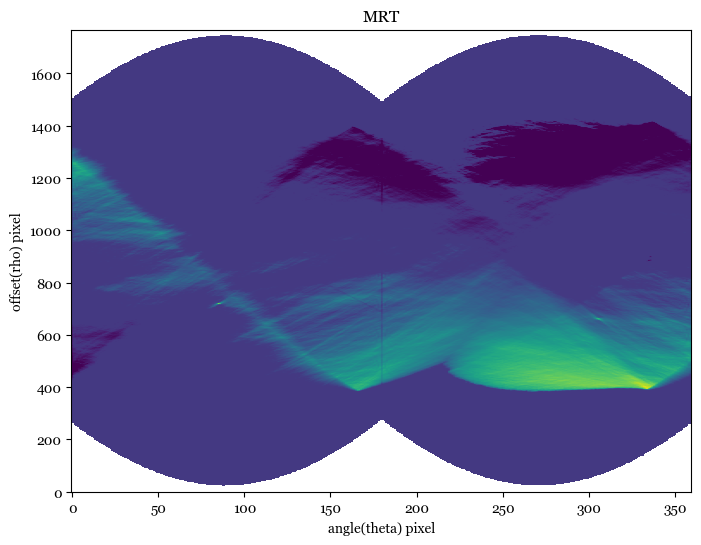

In [33]:
s4.run_mrt()
s4.plot_mrt()

This example has a clear gradient in the background due to the cluster. This causes some large scale variation in the RT, but you can see the "point source" signals from the satellite trails around x,y = 90,700 and x,y = 300,700. Now we'll see if we can pull them out.

In [34]:
s4.find_mrt_sources()
s4.source_list

INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width15.fits
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/photutils/detection/starfinder.py:324: RuntimeWarning: invalid value encountered in true_divide
  return moments / self.moments[:, 0, 0][:, np.newaxis, np.newaxis]
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/photutils/detection/starfinder.py:315: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(self.flux)
INFO:findsat_mrt:33 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width7.fits
/Users/dstark/miniconda3/envs/satellite_trails/lib/python3.9/site-packages/photutils/detection/starfinder.py:324: RuntimeWarning: invalid value encountered in true_divide
  return moments / self.moments[:, 0, 0][:, np.newaxis, np.newaxis]
/Users/dstar

<QTable length=35>
  id      xcentroid      ...                endpoints                status
int64      float64       ...               float64[2,2]              int64 
----- ------------------ ... --------------------------------------- ------
    1  269.0260097049431 ...  698.0330231040379 .. 684.3203809020333      0
    2  166.1349163720854 ...                0.0 .. 1178.457293375882      0
    3 333.79965473681034 ...    975.5792540121622 .. 51.060380692732      0
    4  234.8466319422198 ... 442.40191540457346 .. 807.4827465756248      0
    5  154.2921099489742 ...                0.0 .. 1208.192819100354      0
    7 222.75765325816823 ... 221.26190795494327 .. 823.6719078821031      0
    8  356.5404134256128 ...                981.9531550965685 .. 0.0      0
    9 135.00481048445187 ...                           0.0 .. 1226.0      0
   10  356.5524166497814 ...                923.3617802050672 .. 0.0      0
   11 121.91521896141467 ...                           0.0 .. 1226.0      0
   12 356.41867480799755 ...                857.2994259707451 .. 0.0      0
   13  113.0571165413614 ...                           0.0 .. 1226.0      0
   14  306.0775875138333 ...                565.6197937912478 .. 0.0      0
   15  356.5301102620043 ...                822.3621304016227 .. 0.0      0
   16 102.96095350700963 ...                           0.0 .. 1226.0      0
   17  356.5677496117725 ...                796.9990995013685 .. 0.0      0
   18  85.98673612994655 ...                           0.0 .. 1226.0      0
   19  93.38162509942389 ...                           0.0 .. 1226.0      0
   20  356.7373013540926 ...                734.5644042319698 .. 0.0      0
   21  181.8239851261531 ...                 -0.0 .. 698.44577728979      0
   22   356.640056997693 ...                697.7425865844514 .. 0.0      0
   23  69.19446816201922 ...            211.45144340654193 .. 1226.0      0
   24  58.14400297334511 ...             343.9285298276699 .. 1226.0      0
   25  3.520570379109009 ...             688.0928852604881 .. 1226.0      0
   26  51.82281039887063 ...             441.9944406034993 .. 1226.0      0
   27 3.3847954792547292 ...             750.9252094565992 .. 1226.0      0
   28  41.94252074648929 ...             550.6609982787459 .. 1226.0      0
   29   3.37111865135134 ...             797.8653365901921 .. 1226.0      0
   30 33.556095968220625 ...             649.2284003763237 .. 1226.0      0
   31 27.348710889000053 ...             721.4729022655064 .. 1226.0      0
   33 2.6915411051757494 ...             865.2572356534496 .. 1226.0      0
   36 2.6046121256800125 ...             930.3488363249087 .. 1226.0      0
   40   2.49387455116795 ...             979.5000337407658 .. 1226.0      0
   75 321.96707755327526 ...                 482.251183233081 .. 0.0      0
  141 193.98170200239738 ...               -0.0 .. 740.9810100848395      0

<AxesSubplot: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

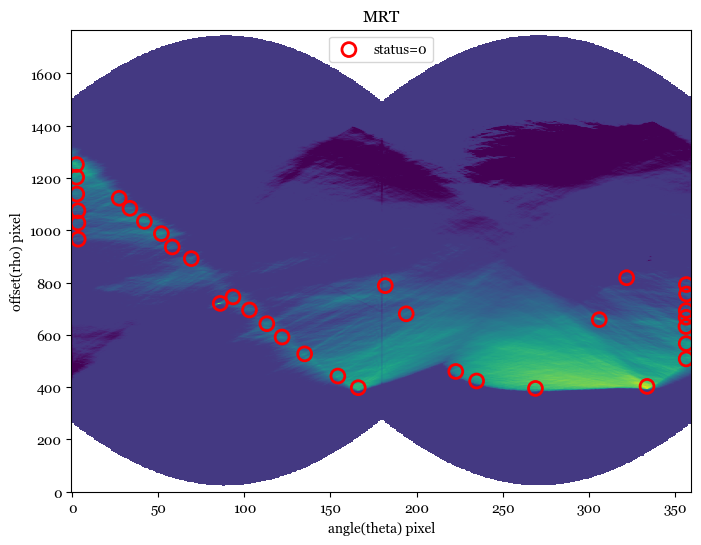

In [35]:
s4.plot_mrt(show_sources=True)

It's clearly shredding those large-scale features quite a bit, but we'll try to filter these out.

INFO:findsat_mrt:Filtering sources...
INFO:findsat_mrt:Min SNR : 5
INFO:findsat_mrt:Max Width: 75
INFO:findsat_mrt:Min Length: 25
INFO:findsat_mrt:Check persistence: True
INFO:findsat_mrt:Min persistence: 0.5
INFO:utils_findsat_mrt:amplitude of feature: 39.93435356791937
INFO:utils_findsat_mrt:baseline noise: 14.253259286355116
INFO:utils_findsat_mrt:snr of feature = 1.8017699506911518
INFO:utils_findsat_mrt:width of feature = 106.3527201363072
INFO:utils_findsat_mrt:amplitude of feature: 70.67425481371215
INFO:utils_findsat_mrt:baseline noise: 9.616954299352123
INFO:utils_findsat_mrt:snr of feature = 6.348922810049472
INFO:utils_findsat_mrt:width of feature = 101.50473319457274
INFO:utils_findsat_mrt:amplitude of feature: 113.6831096079471
INFO:utils_findsat_mrt:baseline noise: 10.61436901894205
INFO:utils_findsat_mrt:snr of feature = 9.710303118826188
INFO:utils_findsat_mrt:width of feature = 93.53652227586775
INFO:utils_findsat_mrt:amplitude of feature: -24.337766896359817
INFO:util

INFO:utils_findsat_mrt:snr of feature = 8.0364144271978
INFO:utils_findsat_mrt:width of feature = 7.924912225710898
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 8.0364144271978, 7.924912225710898, 250.68807520780297
INFO:utils_findsat_mrt:Checking persistence, step 13 of 13
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:279: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak-noise)/noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
INFO:utils_findsat_mrt:baseline noise: 0.0
INFO:utils_findsat_mrt:snr of feature = nan
INFO:utils_findsat_mrt:width of feature = 7.924912225710841
INFO:utils_findsat_mrt:Chunk snr, width ,mean: nan, 7.924912225710841, 250.68807520780297
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:persistance: 0.7692307692307693
INFO:utils_findsat_mrt:amplitude of feature: -3.399112894190065
INFO:utils_findsat_mrt:baseline noise: 12.957326174367095
INFO:utils_findsat_mrt:snr of feature = 

INFO:utils_findsat_mrt:baseline noise: 1.4992726478467355
INFO:utils_findsat_mrt:snr of feature = 7.2098022965758215
INFO:utils_findsat_mrt:width of feature = 21.382233807085186
INFO:utils_findsat_mrt:breaking into 5.0 sections for persistence check
INFO:utils_findsat_mrt:Section size for persistence check: 245.0
INFO:utils_findsat_mrt:Checking persistence, step 1 of 5
INFO:utils_findsat_mrt:amplitude of feature: 10.15009317720876
INFO:utils_findsat_mrt:baseline noise: 10.507749106583391
INFO:utils_findsat_mrt:snr of feature = -0.034037349554772924
INFO:utils_findsat_mrt:width of feature = 11.523253612096596
INFO:utils_findsat_mrt:Chunk snr, width ,mean: -0.034037349554772924, 11.523253612096596, 243.16765679574593
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 2 of 5
INFO:utils_findsat_mrt:amplitude of feature: 0.4603131245557961
INFO:utils_findsat_mrt:baseline noise: 13.933471439832156
INFO:utils_findsat_mrt:snr of feature

INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 11 of 14
INFO:utils_findsat_mrt:amplitude of feature: 54.06471477912136
INFO:utils_findsat_mrt:baseline noise: 21.603829303526698
INFO:utils_findsat_mrt:snr of feature = 1.5025523956669855
INFO:utils_findsat_mrt:width of feature = 40.85942779929775
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 1.5025523956669855, 40.85942779929775, 252.69902252254784
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 12 of 14
INFO:utils_findsat_mrt:amplitude of feature: 22.275156036254344
INFO:utils_findsat_mrt:baseline noise: 14.610621054054521
INFO:utils_findsat_mrt:snr of feature = 0.5245865287891288
INFO:utils_findsat_mrt:width of feature = 35.40196988480449
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 0.5245865287891288, 35.40196988480449, 253.0429142500748
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_find

<AxesSubplot: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

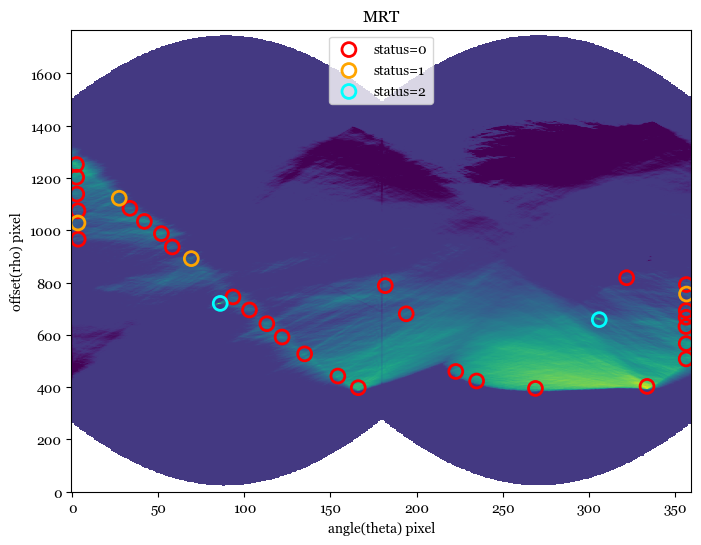

In [36]:
s4.filter_sources(plot=False)
s4.plot_mrt(show_sources=True)

Let's re-plot the MRT with sources to see what made it through

<AxesSubplot: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

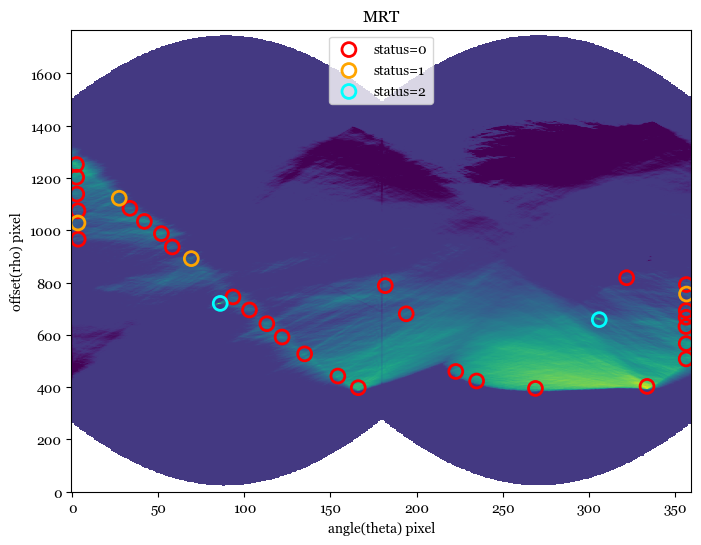

In [37]:
s4.plot_mrt(show_sources=True)

That seems to have worked! Let's make the map to confirm

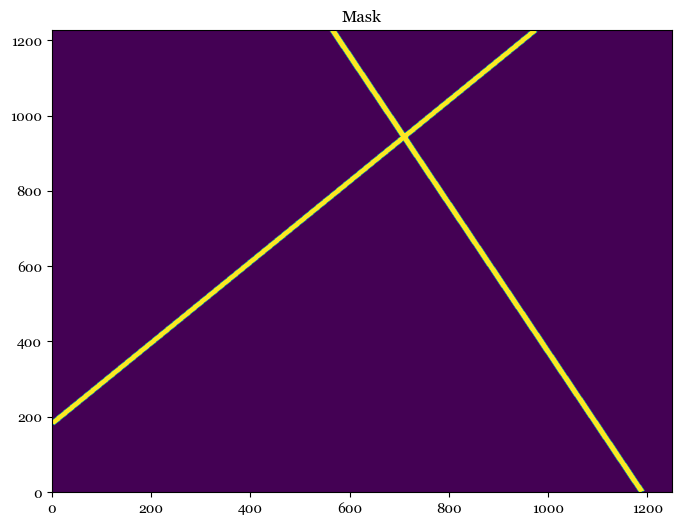

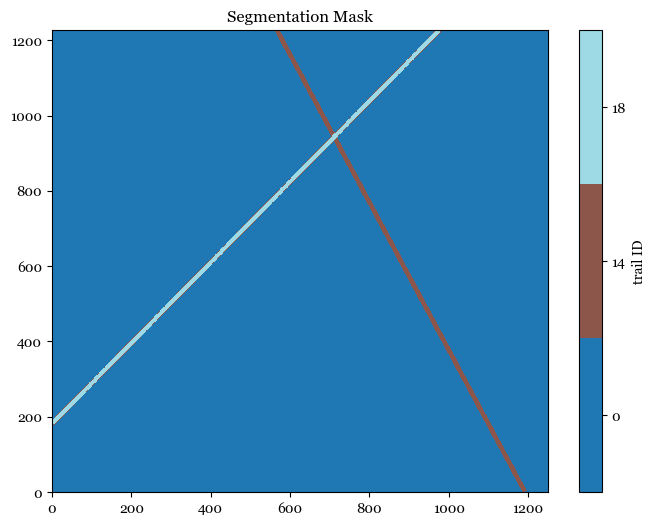

In [38]:
s4.make_mask()
s4.plot_mask()
s4.plot_segment()

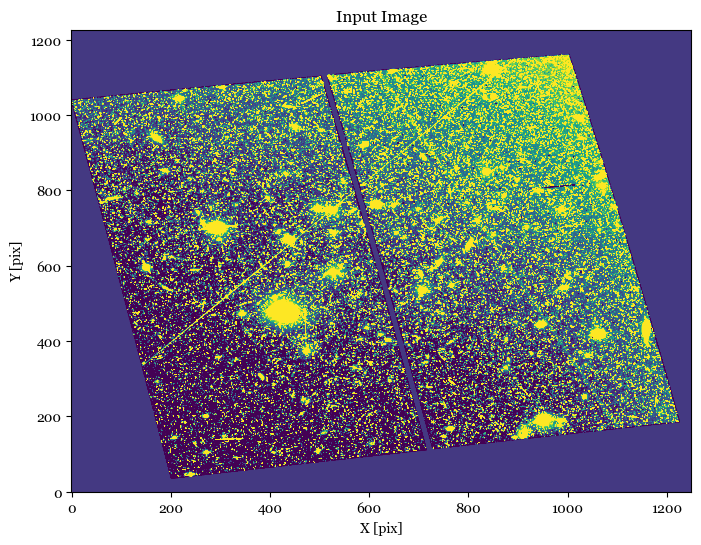

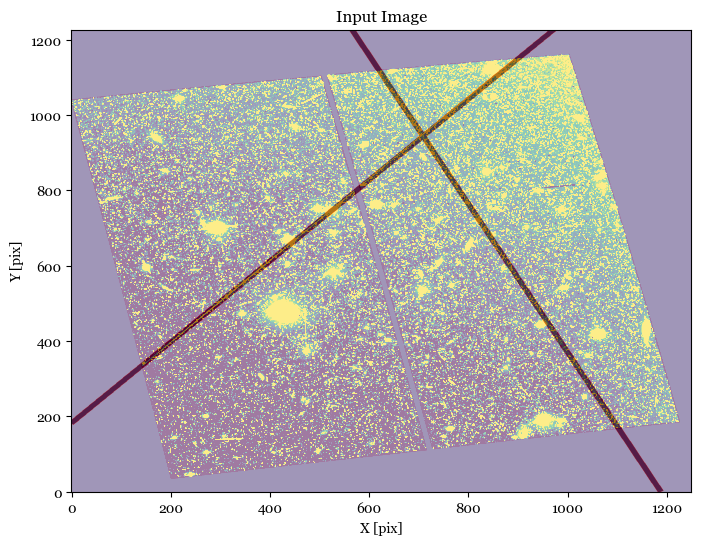

In [39]:
#Let's make a version plotting the mask on top
s4.plot_image()
s4.plot_image(overlay_mask=True)

<a id="example5"></a>
## Example 5:  Quick run on a DRC image

All of the setup from the last example can be streamlined using the WfcWrapper class.

In [40]:
from acstools.findsat_mrt import WfcWrapper
w2 = WfcWrapper('hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits',binsize=4,extension=1,threads=8,output_root = 'example5')

INFO:findsat_mrt:image type is drc
INFO:findsat_mrt:masking bad pixels
INFO:findsat_mrt:Subtracting median background
INFO:findsat_mrt:Rebinning the data by 4


Run full pipeline now

In [41]:
w2.run_all()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 threads
INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width15.fits


(360, 2, 1768)


INFO:findsat_mrt:11 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width7.fits
INFO:findsat_mrt:20 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/python_packages/acstools/acstools/data/rt_line_kernel_width3.fits
INFO:findsat_mrt:42 sources found using kernel
INFO:findsat_mrt:Removing duplicate sources
INFO:findsat_mrt:23 final sources found
INFO:findsat_mrt:Filtering sources...
INFO:findsat_mrt:Min SNR : 5
INFO:findsat_mrt:Max Width: 75
INFO:findsat_mrt:Min Length: 25
INFO:findsat_mrt:Check persistence: True
INFO:findsat_mrt:Min persistence: 0.5
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:279: RuntimeWarning: divide by zero encountered in double_scalars
  snr = (peak-noise)/noise
INFO:utils_findsat_mrt:amplitude of feature: 0.011604164727032185
INFO:utils_findsat_mrt:baseline noise: 0.0
INFO:utils_findsat_mrt:snr of feature = inf
INFO:utils_findsat_mrt:width of

INFO:utils_findsat_mrt:Checking persistence, step 3 of 13
INFO:utils_findsat_mrt:amplitude of feature: 0.10722616364773419
INFO:utils_findsat_mrt:baseline noise: 0.01414237372089388
INFO:utils_findsat_mrt:snr of feature = 6.58190709451545
INFO:utils_findsat_mrt:width of feature = 12.00465625388901
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 6.58190709451545, 12.00465625388901, 252.2628926376288
INFO:utils_findsat_mrt:Checking persistence, step 4 of 13
INFO:utils_findsat_mrt:amplitude of feature: 0.11023291625103308
INFO:utils_findsat_mrt:baseline noise: 0.00945137174747272
INFO:utils_findsat_mrt:snr of feature = 10.663165855317159
INFO:utils_findsat_mrt:width of feature = 13.630832113143384
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 10.663165855317159, 13.630832113143384, 251.6576305805099
INFO:utils_findsat_mrt:Checking persistence, step 5 of 13
INFO:utils_findsat_mrt:amplitude of feature: 0.09121906156685486
INFO:utils_findsat_mrt:baseline noise: 0.017365780068617827
INFO:util

INFO:utils_findsat_mrt:Checking persistence, step 8 of 14
INFO:utils_findsat_mrt:amplitude of feature: 0.6275459846870636
INFO:utils_findsat_mrt:baseline noise: 0.015017641540275
INFO:utils_findsat_mrt:snr of feature = 40.78725287882801
INFO:utils_findsat_mrt:width of feature = 3.996510437584732
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 40.78725287882801, 3.996510437584732, 251.19877432709626
INFO:utils_findsat_mrt:Checking persistence, step 9 of 14
INFO:utils_findsat_mrt:amplitude of feature: 0.4242915898554881
INFO:utils_findsat_mrt:baseline noise: 0.012488501076767754
INFO:utils_findsat_mrt:snr of feature = 32.974580876226526
INFO:utils_findsat_mrt:width of feature = 3.1007585022766193
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 32.974580876226526, 3.1007585022766193, 251.21996968700668
INFO:utils_findsat_mrt:Checking persistence, step 10 of 14
INFO:utils_findsat_mrt:amplitude of feature: 0.3987685614414757
INFO:utils_findsat_mrt:baseline noise: 0.010525306376515919
INFO:uti

INFO:utils_findsat_mrt:Checking persistence, step 11 of 12
INFO:utils_findsat_mrt:amplitude of feature: 0.02301385829316862
INFO:utils_findsat_mrt:baseline noise: 0.009899244780112232
INFO:utils_findsat_mrt:snr of feature = 1.3248094985391101
INFO:utils_findsat_mrt:width of feature = 24.248550404730793
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 1.3248094985391101, 24.248550404730793, 250.79703292590617
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 12 of 12
INFO:utils_findsat_mrt:amplitude of feature: 0.0011877508556080267
INFO:utils_findsat_mrt:baseline noise: 0.0016983621999340128
INFO:utils_findsat_mrt:snr of feature = -0.3006492633584433
INFO:utils_findsat_mrt:width of feature = 224.66473781176256
INFO:utils_findsat_mrt:Chunk snr, width ,mean: -0.3006492633584433, 224.66473781176256, 250.79703292590617
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:persistance: 0.0
/Users/dstark/pyt

INFO:utils_findsat_mrt:breaking into 14.0 sections for persistence check
INFO:utils_findsat_mrt:Section size for persistence check: 100
INFO:utils_findsat_mrt:Checking persistence, step 1 of 14
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:279: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak-noise)/noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
INFO:utils_findsat_mrt:baseline noise: 0.0
INFO:utils_findsat_mrt:snr of feature = nan
INFO:utils_findsat_mrt:width of feature = 48.82371865640161
INFO:utils_findsat_mrt:Chunk snr, width ,mean: nan, 48.82371865640161, 248.38862370430303
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 2 of 14
INFO:utils_findsat_mrt:amplitude of feature: 0.06799301015009124
INFO:utils_findsat_mrt:baseline noise: 0.007454327603850125
INFO:utils_findsat_mrt:snr of feature = 8.121280115858227
INFO:utils_findsat_mrt:width of feature = 48.46032903520179

INFO:utils_findsat_mrt:Checking persistence, step 4 of 14
INFO:utils_findsat_mrt:amplitude of feature: 0.022484409847670972
INFO:utils_findsat_mrt:baseline noise: 0.01491998969895597
INFO:utils_findsat_mrt:snr of feature = 0.5069990195264227
INFO:utils_findsat_mrt:width of feature = 23.47435937910859
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 0.5069990195264227, 23.47435937910859, 267.35614774354707
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 5 of 14
INFO:utils_findsat_mrt:amplitude of feature: 0.04370267022300615
INFO:utils_findsat_mrt:baseline noise: 0.011351360620061656
INFO:utils_findsat_mrt:snr of feature = 2.849993995060724
INFO:utils_findsat_mrt:width of feature = 44.989939576563415
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 2.849993995060724, 44.989939576563415, 272.9455163183161
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 6 of 14
INFO:utils_

INFO:utils_findsat_mrt:Checking persistence, step 6 of 12
INFO:utils_findsat_mrt:amplitude of feature: 0.015908232428020468
INFO:utils_findsat_mrt:baseline noise: 0.0186192744436509
INFO:utils_findsat_mrt:snr of feature = -0.1456040633503249
INFO:utils_findsat_mrt:width of feature = 2.9581572431137033
INFO:utils_findsat_mrt:Chunk snr, width ,mean: -0.1456040633503249, 2.9581572431137033, 250.94607429879744
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 7 of 12
INFO:utils_findsat_mrt:amplitude of feature: 0.036606029616243256
INFO:utils_findsat_mrt:baseline noise: 0.006738296692383846
INFO:utils_findsat_mrt:snr of feature = 4.432534553964992
INFO:utils_findsat_mrt:width of feature = 37.13603907036108
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 4.432534553964992, 37.13603907036108, 250.94607429879744
INFO:utils_findsat_mrt:Checking persistence, step 8 of 12
INFO:utils_findsat_mrt:amplitude of feature: 0.09180937056868367
IN

INFO:utils_findsat_mrt:amplitude of feature: 0.04100035386107715
INFO:utils_findsat_mrt:baseline noise: 0.010072282409562374
INFO:utils_findsat_mrt:snr of feature = 3.0706120215764043
INFO:utils_findsat_mrt:width of feature = 23.611346009217158
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 3.0706120215764043, 23.611346009217158, 266.0915579467266
INFO:utils_findsat_mrt:Checking persistence, step 12 of 14
INFO:utils_findsat_mrt:amplitude of feature: 0.015712993700365295
INFO:utils_findsat_mrt:baseline noise: 0.014812028868677742
INFO:utils_findsat_mrt:snr of feature = 0.06082656465737642
INFO:utils_findsat_mrt:width of feature = 23.61104668841483
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 0.06082656465737642, 23.61104668841483, 266.0915554538858
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 13 of 14
INFO:utils_findsat_mrt:amplitude of feature: 0.012292567534716768
INFO:utils_findsat_mrt:baseline noise: 3.261208341883397

INFO:utils_findsat_mrt:Section size for persistence check: 100
INFO:utils_findsat_mrt:Checking persistence, step 1 of 13
INFO:utils_findsat_mrt:amplitude of feature: -0.0011205539021712815
INFO:utils_findsat_mrt:baseline noise: 0.0009727610804824248
INFO:utils_findsat_mrt:snr of feature = -2.1519312651936704
INFO:utils_findsat_mrt:width of feature = 51.08991228676754
INFO:utils_findsat_mrt:Chunk snr, width ,mean: -2.1519312651936704, 51.08991228676754, 250.71237505882155
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 2 of 13
INFO:utils_findsat_mrt:amplitude of feature: 0.028219033816958804
INFO:utils_findsat_mrt:baseline noise: 0.0027307545106095878
INFO:utils_findsat_mrt:snr of feature = 9.333786397613403
INFO:utils_findsat_mrt:width of feature = 35.0635892050897
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 9.333786397613403, 35.0635892050897, 258.89149259487766
INFO:utils_findsat_mrt:Checking persistence, step 3 of 13
IN

INFO:utils_findsat_mrt:amplitude of feature: 0.1867109906540646
INFO:utils_findsat_mrt:baseline noise: 0.014532478533437239
INFO:utils_findsat_mrt:snr of feature = 11.847842178088772
INFO:utils_findsat_mrt:width of feature = 157.18717433778858
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 11.847842178088772, 157.18717433778858, 248.99649251594715
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 5 of 12
INFO:utils_findsat_mrt:amplitude of feature: -0.009226303735238084
INFO:utils_findsat_mrt:baseline noise: 0.019148326350803234
INFO:utils_findsat_mrt:snr of feature = -1.4818334284787797
INFO:utils_findsat_mrt:width of feature = 1.6822062403663267
INFO:utils_findsat_mrt:Chunk snr, width ,mean: -1.4818334284787797, 1.6822062403663267, 248.99649251594715
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 6 of 12
INFO:utils_findsat_mrt:amplitude of feature: 0.26107959662998

INFO:utils_findsat_mrt:Chunk snr, width ,mean: 8.802675586230768, 178.4389284528763, 261.91773290682727
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 9 of 12
INFO:utils_findsat_mrt:amplitude of feature: 0.04191893070492717
INFO:utils_findsat_mrt:baseline noise: 0.012624940524587791
INFO:utils_findsat_mrt:snr of feature = 2.3203269847717434
INFO:utils_findsat_mrt:width of feature = 31.852575301176188
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 2.3203269847717434, 31.852575301176188, 260.35114723674627
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 10 of 12
INFO:utils_findsat_mrt:amplitude of feature: 0.0516677315289784
INFO:utils_findsat_mrt:baseline noise: 0.012823740483733467
INFO:utils_findsat_mrt:snr of feature = 3.0290687100629783
INFO:utils_findsat_mrt:width of feature = 204.2743462779083
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 3.0290687100629783, 

INFO:utils_findsat_mrt:baseline noise: 0.0
INFO:utils_findsat_mrt:snr of feature = nan
INFO:utils_findsat_mrt:width of feature = 29.61886168146114
INFO:utils_findsat_mrt:Chunk snr, width ,mean: nan, 29.61886168146114, 251.4517473353465
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:persistance: 0.08333333333333333
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:279: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak-noise)/noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
INFO:utils_findsat_mrt:baseline noise: 0.0
INFO:utils_findsat_mrt:snr of feature = nan
INFO:utils_findsat_mrt:width of feature = 30.0
/Users/dstark/python_packages/acstools/acstools/utils_findsat_mrt.py:279: RuntimeWarning: invalid value encountered in double_scalars
  snr = (peak-noise)/noise
INFO:utils_findsat_mrt:amplitude of feature: 0.0
INFO:utils_findsat_mrt:baseline noise: 0.0
INFO:utils_findsat_mrt:snr of feature = nan
INFO:uti

INFO:utils_findsat_mrt:Chunk snr, width ,mean: nan, 0.0, 253.9950253547811
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 2 of 13
INFO:utils_findsat_mrt:amplitude of feature: -0.004223763851363419
INFO:utils_findsat_mrt:baseline noise: 0.007831930677348997
INFO:utils_findsat_mrt:snr of feature = -1.5393004643898491
INFO:utils_findsat_mrt:width of feature = 1.5795366887606974
INFO:utils_findsat_mrt:Chunk snr, width ,mean: -1.5393004643898491, 1.5795366887606974, 253.9950253547811
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 3 of 13
INFO:utils_findsat_mrt:amplitude of feature: -0.010659074830709513
INFO:utils_findsat_mrt:baseline noise: 0.00711057034573159
INFO:utils_findsat_mrt:snr of feature = -2.499046393248617
INFO:utils_findsat_mrt:width of feature = 1.580353937350253
INFO:utils_findsat_mrt:Chunk snr, width ,mean: -2.499046393248617, 1.580353937350253, 253.99

INFO:utils_findsat_mrt:Checking persistence, step 5 of 13
INFO:utils_findsat_mrt:amplitude of feature: 0.29670736123116676
INFO:utils_findsat_mrt:baseline noise: 0.01283236238444786
INFO:utils_findsat_mrt:snr of feature = 22.121803479518338
INFO:utils_findsat_mrt:width of feature = 52.00369358467506
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 22.121803479518338, 52.00369358467506, 254.09567364915745
INFO:utils_findsat_mrt:Checking persistence, step 6 of 13
INFO:utils_findsat_mrt:amplitude of feature: 0.12181608182461748
INFO:utils_findsat_mrt:baseline noise: 0.015604803484539092
INFO:utils_findsat_mrt:snr of feature = 6.80631950574131
INFO:utils_findsat_mrt:width of feature = 105.04172426422616
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 6.80631950574131, 105.04172426422616, 254.0334160498518
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 7 of 13
INFO:utils_findsat_mrt:amplitude of feature: 0.06467380316040179
INFO:uti

INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 9 of 13
INFO:utils_findsat_mrt:amplitude of feature: 0.33760054184184296
INFO:utils_findsat_mrt:baseline noise: 0.013502112077817017
INFO:utils_findsat_mrt:snr of feature = 24.00353573545697
INFO:utils_findsat_mrt:width of feature = 148.25336543168487
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 24.00353573545697, 148.25336543168487, 256.04070563576386
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_findsat_mrt:Checking persistence, step 10 of 13
INFO:utils_findsat_mrt:amplitude of feature: 0.0852510712803563
INFO:utils_findsat_mrt:baseline noise: 0.010337542412998495
INFO:utils_findsat_mrt:snr of feature = 7.246744523452792
INFO:utils_findsat_mrt:width of feature = 92.708460569603
INFO:utils_findsat_mrt:Chunk snr, width ,mean: 7.246744523452792, 92.708460569603, 255.39102932138664
INFO:utils_findsat_mrt:fit failed, will not update guesses
INFO:utils_find

<AxesSubplot: title={'center': 'Mask'}>

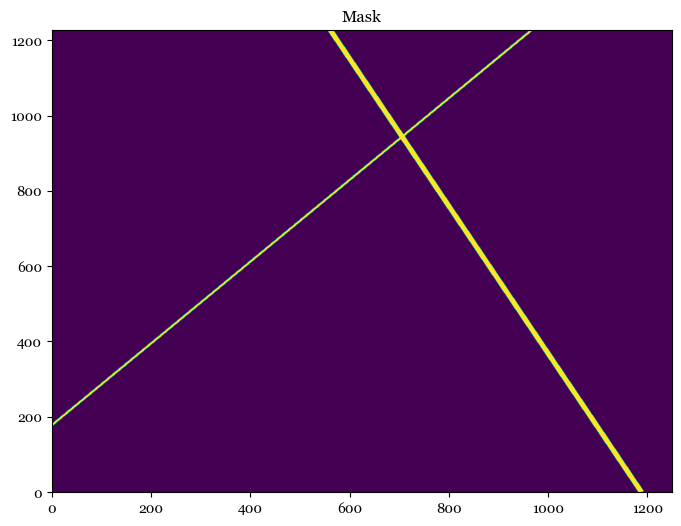

In [42]:
w2.plot_mask()

And there you go!

<a id="example6"></a>
## Example 6:  Create a new kernel for trail detection

We include a function called create_mrt_line_kernel that can be used to generate kernels for detecting trails of s specified size in the MRT. Note that kernels with widths of 1, 3, 7, and 15 pixels (convolved with a simple Gaussian HST/ACS psf model) are included already, but perhaps you want to generate a kernel with a new width, or convolved with a different PSF.

In [43]:
from acstools.utils_findsat_mrt import create_mrt_line_kernel

Let's generate a kernel for a trail that has an inherent width of 5 pixels and is convolved with a Gaussian PSF with sigma=3. 

calculated endpoints: [(-0.0, 511.50000000000006), (1856.6469581395916, 511.49999999999994)]


INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 threads


(180, 2, 2897)


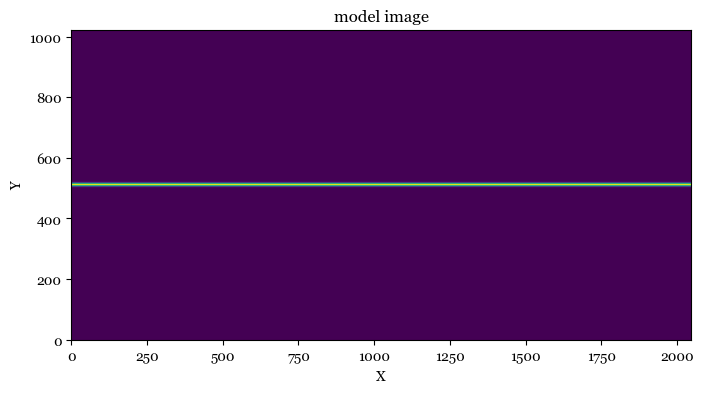

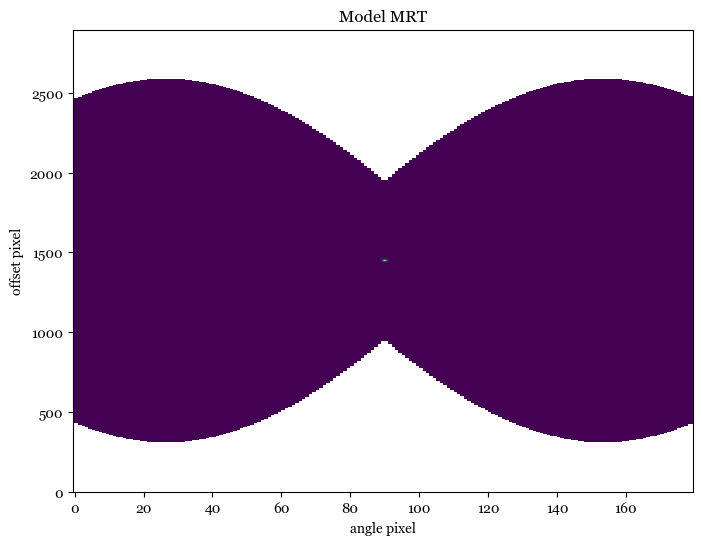

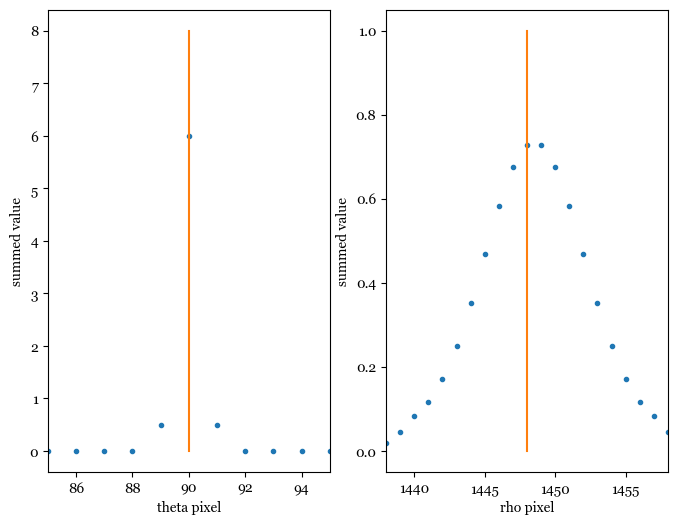

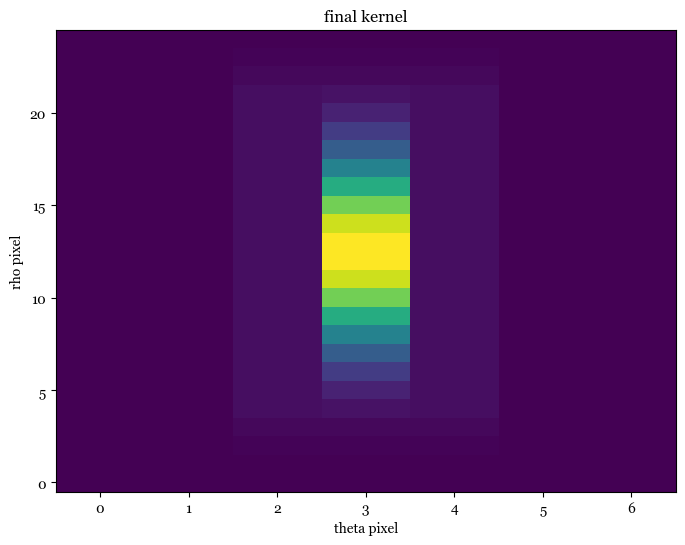

In [44]:
out=create_mrt_line_kernel(5,3,threads=8,plot=True)

<a id="about_ID"></a>
### About this Notebook
**Author:** David V. Stark, ACS Instrument Team <br>
**Updated On:** 1/6/2022